In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

# 1. Cargar datos

[Link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data?select=WA_Fn-UseC_-Telco-Customer-Churn.csv)

In [2]:
DATA_PATH = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# 2. EDA básico

In [3]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())
print(df["Churn"].value_counts())

(7043, 21)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod

# 3. Preprocesamiento

In [4]:
# (a) Borrardo de variables irrelevantes
df = df.drop(columns=["customerID"])

In [5]:
# (b) Convertir total charges a numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [6]:
# (c) Definir target and predictores
target_col = "Churn"
y = (df[target_col] == "Yes").astype(int).values  # binary 0/1

# Separar features
X = df.drop(columns=[target_col])

# Identificar variables numericas vs categoricas
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_features = [c for c in X.columns if c not in num_features]

In [7]:
num_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [8]:
cat_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [9]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


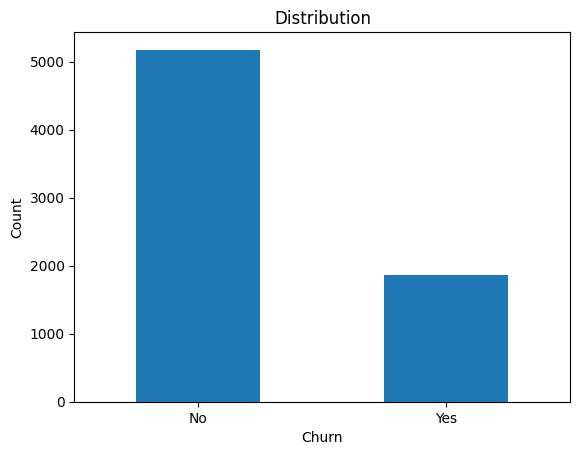

In [10]:
counts = df['Churn'].value_counts()
counts.plot.bar(rot=0) # rot=0 prevents x-axis labels from rotating
plt.title('Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 4. Construir pipeline de preprocessing

In [11]:
# Imputación de missing values
num_imputer = SimpleImputer(strategy="median")
# Para categorías, rellenamos los valores faltantes con un valor especial.
cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")

In [12]:
# Encoders / scalers
num_scaler = StandardScaler()
# OneHotEncoder 
cat_encoder = OneHotEncoder(handle_unknown="ignore")

In [13]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_imputer), ("scaler", num_scaler)]), num_features),
        ("cat", Pipeline([("imputer", cat_imputer), ("ohe", cat_encoder)]), cat_features),
    ],
    remainder="drop",  # drop any other columns
)

# 5. Train / validation / test split

In [14]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

In [15]:
# Ajustar preprocessing en el conjunto training
preprocessor.fit(X_train)

# Transformamos
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

input_dim = X_train_prep.shape[1]

In [16]:
X_train_prep.shape

(5088, 46)

# 6. Definimos nuestro modelo NN

In [17]:
def make_model(input_dim, dropout_rate=0.3, hidden_units=[64, 32]):
    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
        
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

model = make_model(input_dim=input_dim, dropout_rate=0.3, hidden_units=[64, 64, 32,])

I0000 00:00:1763509725.953419  120794 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13638 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9


In [18]:
def f1_metric(y_true, y_pred):
    """Compute F1 for binary classification as a custom metric."""
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), "int32")
    y_true_int = K.cast(y_true, "int32")
    tp = K.sum(K.cast(y_true_int * y_pred_bin, "float32"))
    fp = K.sum(K.cast((1 - y_true_int) * y_pred_bin, "float32"))
    fn = K.sum(K.cast(y_true_int * (1 - y_pred_bin), "float32"))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3), 
    loss="binary_crossentropy",
    metrics=[f1_metric]
)


In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,281 (36.25 KB)

 Trainable params: 9,281 (36.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
32*64 + 32

2080

# 7. Entrenamiento

In [19]:
early_stop = callbacks.EarlyStopping(
    monitor="val_f1_metric", mode="max", patience=10, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_f1_metric", mode="max", factor=0.5, patience=3
)

history = model.fit(
    X_train_prep,
    y_train,
    validation_data=(X_val_prep, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/100


I0000 00:00:1763085830.789410 1928295 service.cc:152] XLA service 0x78a41800b770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763085830.789462 1928295 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-11-13 20:03:50.846399: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763085831.132490 1928295 cuda_dnn.cc:529] Loaded cuDNN version 91001
I0000 00:00:1763085832.642549 1928295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-13 20:03:55.195751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 8 bytes spill stores, 8 bytes spill loads



159/159 - 6s - 38ms/step - f1_metric: 0.1523 - loss: 0.5065 - val_f1_metric: 0.2428 - val_loss: 0.4378 - learning_rate: 0.0010
Epoch 2/100
159/159 - 0s - 2ms/step - f1_metric: 0.2257 - loss: 0.4483 - val_f1_metric: 0.2320 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 3/100
159/159 - 0s - 3ms/step - f1_metric: 0.2266 - loss: 0.4394 - val_f1_metric: 0.2156 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 4/100
159/159 - 0s - 3ms/step - f1_metric: 0.2231 - loss: 0.4342 - val_f1_metric: 0.2253 - val_loss: 0.4304 - learning_rate: 0.0010
Epoch 5/100
159/159 - 0s - 2ms/step - f1_metric: 0.2243 - loss: 0.4281 - val_f1_metric: 0.2196 - val_loss: 0.4293 - learning_rate: 5.0000e-04
Epoch 6/100
159/159 - 0s - 3ms/step - f1_metric: 0.2307 - loss: 0.4214 - val_f1_metric: 0.2239 - val_loss: 0.4298 - learning_rate: 5.0000e-04
Epoch 7/100
159/159 - 0s - 3ms/step - f1_metric: 0.2278 - loss: 0.4192 - val_f1_metric: 0.2089 - val_loss: 0.4305 - learning_rate: 5.0000e-04
Epoch 8/100
159/159 - 0s - 3ms/st

# 8. Evaluación sobre test

In [20]:
y_test_pred_prob = model.predict(X_test_prep).ravel()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print("Test F1:", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test F1: 0.6017391304347826
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       777
           1       0.59      0.62      0.60       280

    accuracy                           0.78      1057
   macro avg       0.72      0.73      0.73      1057
weighted avg       0.79      0.78      0.79      1057

Confusion matrix:
 [[655 122]
 [107 173]]


# 9. Guardamos modelo

In [21]:
model.save("../models/churn_model.h5")

In [22]:
import joblib
joblib.dump(preprocessor, "preprocessor.joblib")

['preprocessor.joblib']